# Conv-model with Loss-Attention

## Import packages

In [1]:
import glob
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits

from tqdm import tqdm

from inverse_problem import HinodeME
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer, plot_analysis_hist2d
from inverse_problem.nn_inversion.posthoc import open_spectrum_data, real_spectra, plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion.transforms import normalize_output, inverse_transformation

from inverse_problem.nn_inversion.model_pi_mlp_conv import PIMLPConvNet
from inverse_problem.nn_inversion import conv1d_transform_rescale, normalize_spectrum


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
from pathlib import Path

model_name = 'la_old_model'

current_time = str(datetime.now().strftime('%Y-%m-%d_%H-%M'))

save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

save_path

'../la_old_model_2022-03-22_18-36/'

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device.type)

cpu


## Dataset

In [4]:
filename = '../data/parameters_base.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

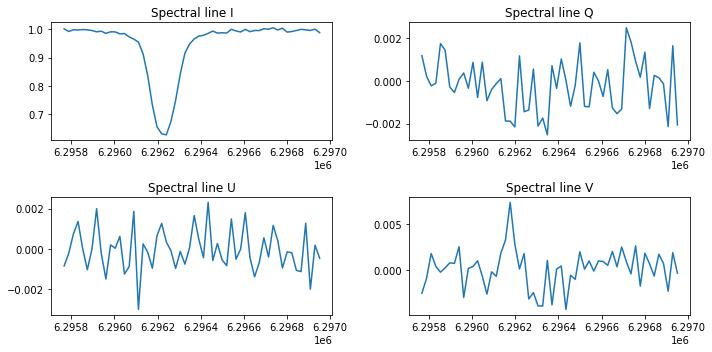

In [5]:
line_type = ['I', 'Q', 'U', 'V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
for i in range(4):
    ax[i // 2][i % 2].plot(line_arg, sample['X'][0][:, i])
    ax[i // 2][i % 2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight=True)
fig.set_facecolor('xkcd:white')

## Data Filtering

In [6]:
params = fits.open(filename)[0].data

In [7]:
def params_masked_rows(pars_arr):
    
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])

    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)

def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)

In [8]:
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

## Dataloader

In [9]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = True, True

transform_name = "conv1d_transform_rescale"

batch_size = 128

In [10]:
train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors=factors, cont_scale=cont_scale,
                                       logB=logB, angle_transformation=angle_transformation,
                                       batch_size=batch_size)

sample_batch = next(iter(train_loader))

print('Size of spectrum batch: ', sample_batch['X'][0].shape)
print('Size of cont batch: ', sample_batch['X'][1].shape)
print('Size of true params batch: ', sample_batch['Y'].shape)

print(f'\nNumber of batches for train: {len(train_loader)}, for validation: {len(val_loader)}')

Size of spectrum batch:  torch.Size([128, 4, 56])
Size of cont batch:  torch.Size([128, 1])
Size of true params batch:  torch.Size([128, 11])

Number of batches for train: 31243, for validation: 3472


In [11]:
attention_c = 14

## Model

In [12]:
model = PIMLPConvNet(n_blocks=6, in_dim=(4, 64, 64, 128, 128, 256), out_dim=(64, 64, 128, 128, 256, 256),
                     kernel_size=(3, 3, 3, 3, 3, 3), padding=(1, 1, 1, 1, 1, 1), activation='elu', dropout=0.05,
                     batch_norm=True, pool=(None, 'max', None, 'max', None, None), hidden_dims=(100, 100),
                     bottom_output=100, number_readout_layers=2, top_output=11)

In [13]:
criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device);

## Model Training

In [28]:
def fit_step(dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="fit_batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break

            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            outputs = model(x)

            optimizer.zero_grad()
            
            losses = [torch.exp(attention_c * torch.abs(y[:, i] - 0.5)) * criterion(outputs[:, i], y[:, i]) 
                      for i in range(11)]
            
            loss = torch.stack(losses).mean()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_it += 1

            if train_it % 10 == 0:
                pbar_outer.update(10)

        return train_loss / train_it


def eval_step(dataloader, max_steps=None):
    model.eval()
    val_loss = 0.0
    val_it = 0
    
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="val_batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break
                
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            with torch.no_grad():
                outputs = model(x)
                losses = [torch.exp(attention_c * torch.abs(y[:, i] - 0.5)) * criterion(outputs[:, i], y[:, i]) 
                          for i in range(11)]

                loss = torch.stack(losses).mean()
                val_loss += loss.item()
                val_it += 1
                
            if val_it % 10 == 0:
                pbar_outer.update(10)
        return val_loss / val_it


def save_model(path, epoch, loss):
    """
    Args:
        path (str): path to save model to
        epoch (int): optional
        loss (float): optional, validation loss
    Returns:
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + model_name + '_' + f'ep{epoch}.pt')


def train(n_epoch, log_dir=None, path_to_save=None, max_steps=None):
    loss_history = []
    best_valid_loss = float('inf')

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=n_epoch, position=0, leave=True) as pbar_outer:
        for epoch in range(n_epoch):
            train_loss = fit_step(train_loader, max_steps=max_steps)
            val_loss = eval_step(val_loader, max_steps=max_steps)
            loss_history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))

            if path_to_save:
                if val_loss < best_valid_loss:
                    best_valid_loss = val_loss
                    save_model(path_to_save, epoch, val_loss)
            
            if log_dir:
                with open(os.path.join(log_dir, 'history_' + model_name + '_' + current_time + '.txt'), 'w') as f:
                    for i, item in enumerate(loss_history):
                        f.write(f"Train loss in epoch {i}: {item[0]: .4f}, val_loss: {item[1]:.4f}\n")

    return loss_history

In [29]:
num_epochs = 5

In [ ]:
%%time

history = train(n_epoch=num_epochs,
                log_dir=save_path,
                path_to_save=save_path)

epoch:  20%|██        | 1/5 [2:29:51<9:59:26, 8991.61s/it]


Epoch 001 train_loss: 7.5968 val_loss 3.2024


fit_batch:  92%|█████████▏| 28670/31243 [1:56:29<10:43,  4.00it/s]  

## Model Analysis

Два варианта:
- Оценка понимание моделью симуляции спектров из референсных значений, полученных обращением реальных спектров
- Оценка качество работы на реальных спектрах

In [14]:
checkpoint_path = save_path + 'la_old_model_ep4.pt'

model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])

<All keys matched successfully>

### Реферер
Посмотрим что он из себя представляет (на самом деле база с параметрами и есть композиция нескольких рефереров)

Несколько примеров лежат подготовленные на гугл диске:
https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [15]:
path_to_refer = '../data/hinode_source/20140926_170005.fits'

Можно с помощью функции сразу нормировать выходы так как это делается для сети, но посмотреть мы можем и сырые данные

In [16]:
ref_unnorm, names = open_param_file(path_to_refer, normalize=False)
ref_unnorm_2d = ref_unnorm.reshape(-1, 11)

ref_shape = ref_unnorm.shape

print('\n', ref_shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift

 (512, 873, 11)


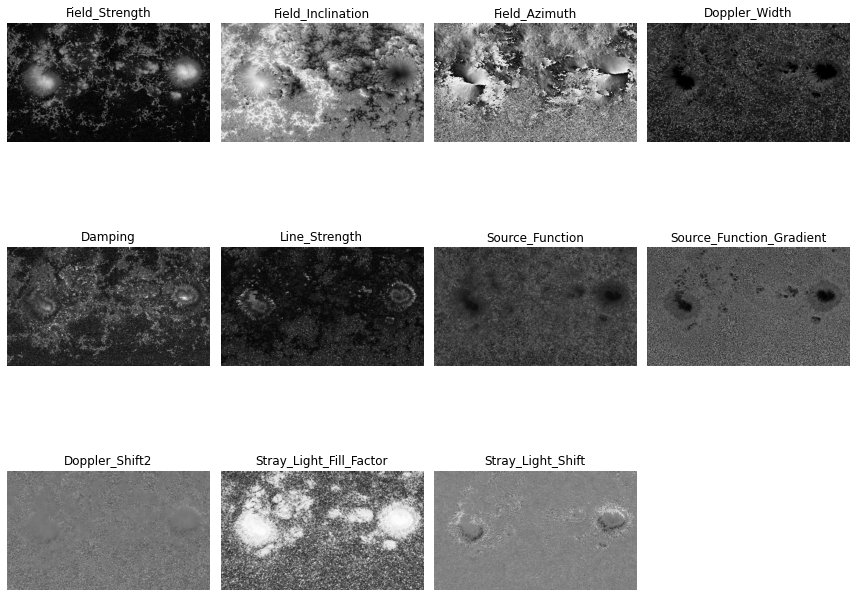

In [17]:
plot_params(ref_unnorm, names=names)

In [18]:
ref_2d = normalize_output(ref_unnorm_2d.copy(),
                          logB=logB,
                          angle_transformation=angle_transformation)

ref = ref_2d.reshape(ref_shape).copy()

### Refer Filtering

In [19]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(ref_shape)

masked_ref_unnorm_2d = create_masked_array(ref_unnorm_2d)
masked_ref_unnorm = masked_ref_unnorm_2d.reshape(ref_shape)

### Тестируем модель на симуляции данных из реферера

тут нам препроцессинг может упростить PregenDataset, можно и руками с помощью  BatchMe приготовить данные (он там и есть). Дальше надо загрузить 500k параметров и сделать симуляцию, поэтому работает это долго (в SpectrumDataset генерация во время обучения, поэтому надо только считать параметры и это быстро)

In [20]:
%%time

transform = conv1d_transform_rescale(factors=factors, 
                                     angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB)

test_dataset = PregenSpectrumDataset(data_arr=masked_ref_unnorm_2d,
                                     transform=transform)

CPU times: user 52 s, sys: 15.8 s, total: 1min 7s
Wall time: 1min 8s


In [21]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [22]:
%%time

model.eval()
with torch.no_grad():
    predicted = model(sim_x)

CPU times: user 3min 33s, sys: 5min 7s, total: 8min 40s
Wall time: 10min 31s


In [23]:
predicted = predicted.detach().cpu().numpy()
predicted_2d = predicted.reshape(-1, 11).copy()

In [24]:
fe_names = names.copy()
fe_names[0] = 'log(Field_Strength)' if logB else 'Field_Strength'
fe_names[1] = 'cos(Field_Inclination)' if angle_transformation else 'Field_Inclination'
fe_names[2] = 'cos(Field_Azimuth)' if angle_transformation else 'Field_Azimuth'

In [25]:
compute_metrics(masked_ref_2d.data, predicted_2d,
                names=fe_names,
                save_path=save_path+model_name+'.csv', 
                mask=masked_ref_2d.mask)

,r2,mse,mae
log(Field_Strength),0.8250,0.0040,0.0341
cos(Field_Inclination),0.9204,0.0068,0.0526
cos(Field_Azimuth),0.8222,0.0208,0.0783
Doppler_Width,0.8497,0.0028,0.0354
Damping,0.7885,0.0043,0.0365
Line_Strength,0.6033,0.0032,0.0252
Source_Function,0.5611,0.0021,0.0335
Source_Function_Gradient,0.9420,0.0006,0.0173
Doppler_Shift2,0.8633,0.0002,0.0105
Stray_Light_Fill_Factor,0.6538,0.0294,0.1210


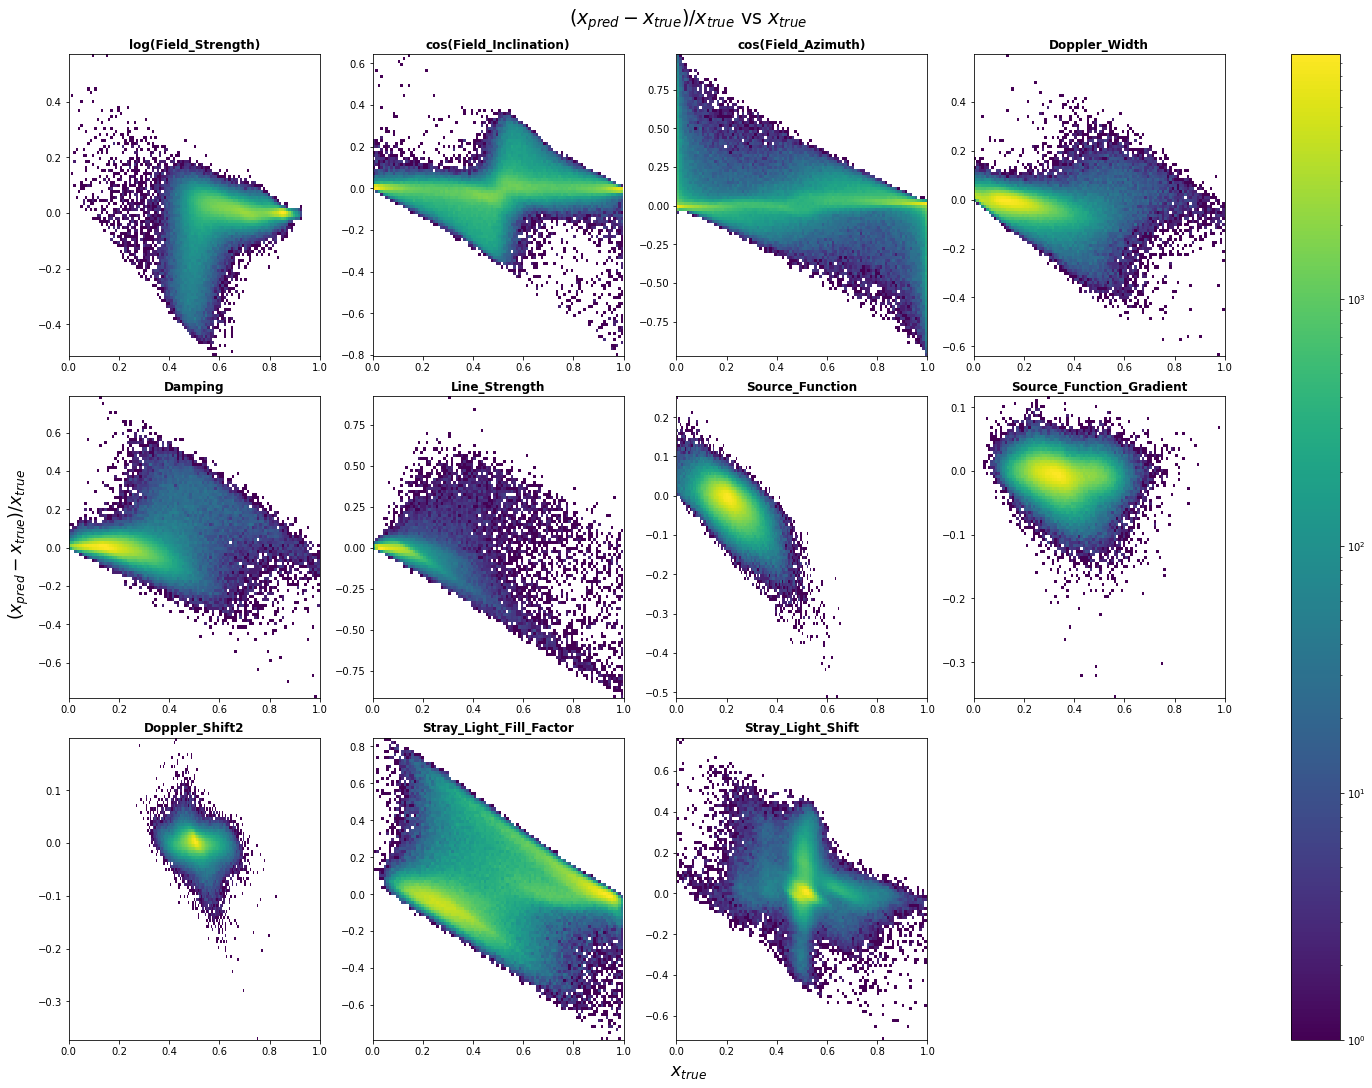

In [28]:
fig, axs = plot_analysis_hist2d(masked_ref_2d.data, predicted_2d, 
                                names=fe_names,
                                save_path=save_path+model_name+'_analysis_hist2d',
                                mask=masked_ref_2d.mask)

custom_xlim = (0, 1)
# custom_ylim = (-1, 1)
# plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(axs, xlim=custom_xlim)

plt.show()

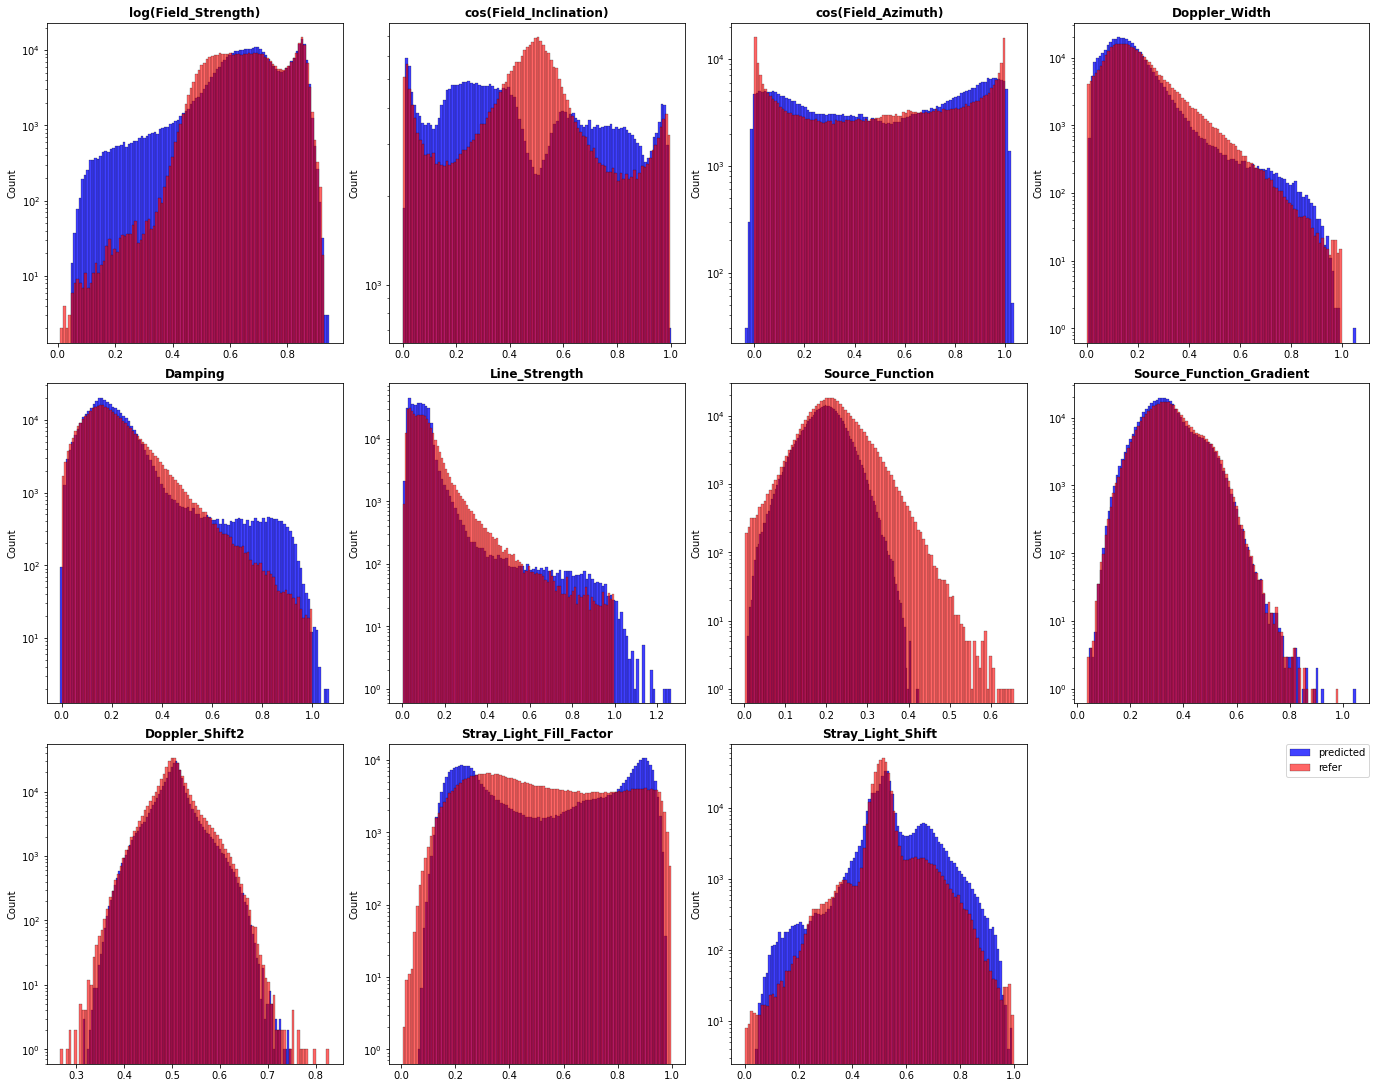

In [29]:
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison

plot_hist_params_comparison(predicted_2d, masked_ref_2d.data, 
                            pars_names=fe_names,
                            save_path=save_path+model_name+'_comp_plot',
                            mask=masked_ref_2d.mask)
plt.show()

## Обратные преобразования параметров

In [30]:
broken_rows = np.any((predicted_2d[:, [1,2]] > 1) + (predicted_2d[:, [1,2]] < 0), axis=1)
sum(broken_rows)

14320

In [31]:
mask_range = broken_rows[:, np.newaxis] | np.zeros_like(predicted_2d, dtype=bool)
combined_mask = mask_range + masked_ref_2d.mask

predicted_2d_prep = predicted_2d.copy()

predicted_2d_prep[:, 1:3] = np.clip(predicted_2d_prep[:, 1:3], 0, 1)

In [32]:
predicted_2d_inv = inverse_transformation(predicted_2d_prep,
                                          inv_logB=logB,
                                          inv_angle_transformation=angle_transformation)

In [33]:
compute_metrics(masked_ref_unnorm_2d.data, predicted_2d_inv, 
                save_path=save_path+model_name+'_inv' + '.csv',
                mask=combined_mask)

,r2,mse,mae
Field Strength,0.9690,7.587125e+03,62.3091
Field Inclination,0.9265,1.137238e+02,7.0755
Field Azimuth,0.7800,4.928873e+02,12.5024
Doppler Width,0.8501,1.403100e+01,2.4947
Damping,0.7893,9.800000e-03,0.0549
Line Strength,0.5998,3.219460e+01,2.5245
S_0,0.5625,3.195685e+06,1295.7943
S_1,0.9430,2.037945e+06,1044.5651
Doppler Shift,0.8645,9.340000e-02,0.2099
Filling Factor,0.6478,2.960000e-02,0.1217


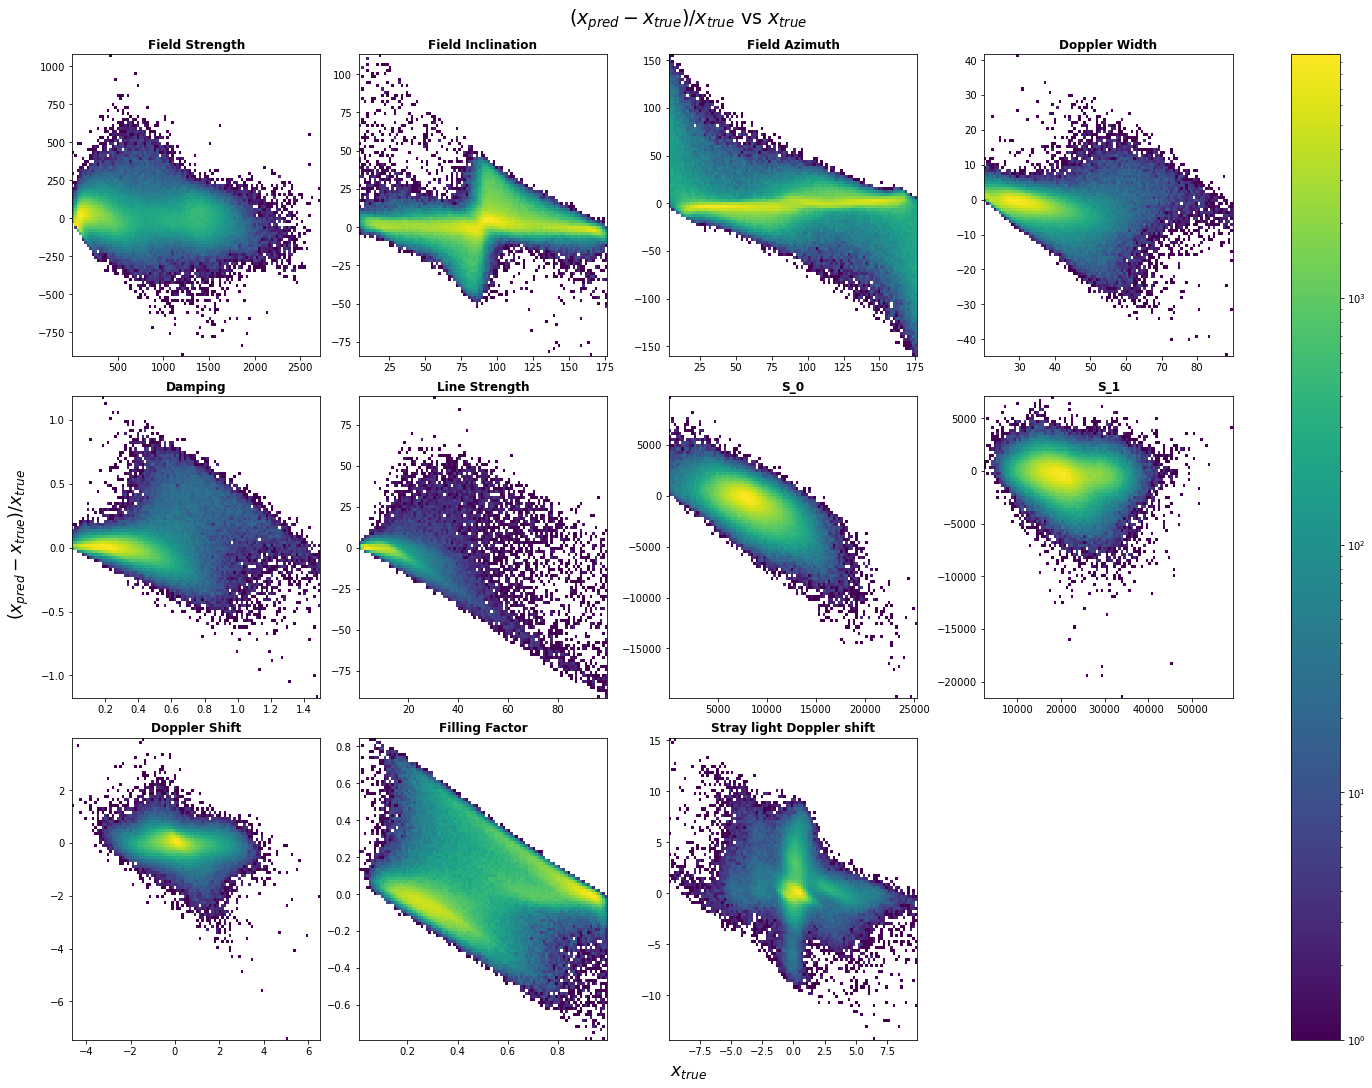

In [34]:
plot_analysis_hist2d(masked_ref_unnorm_2d.data, predicted_2d_inv, 
                     save_path=save_path+model_name+'_analysis_hist2d_inv', 
                     mask=combined_mask)

plt.show()

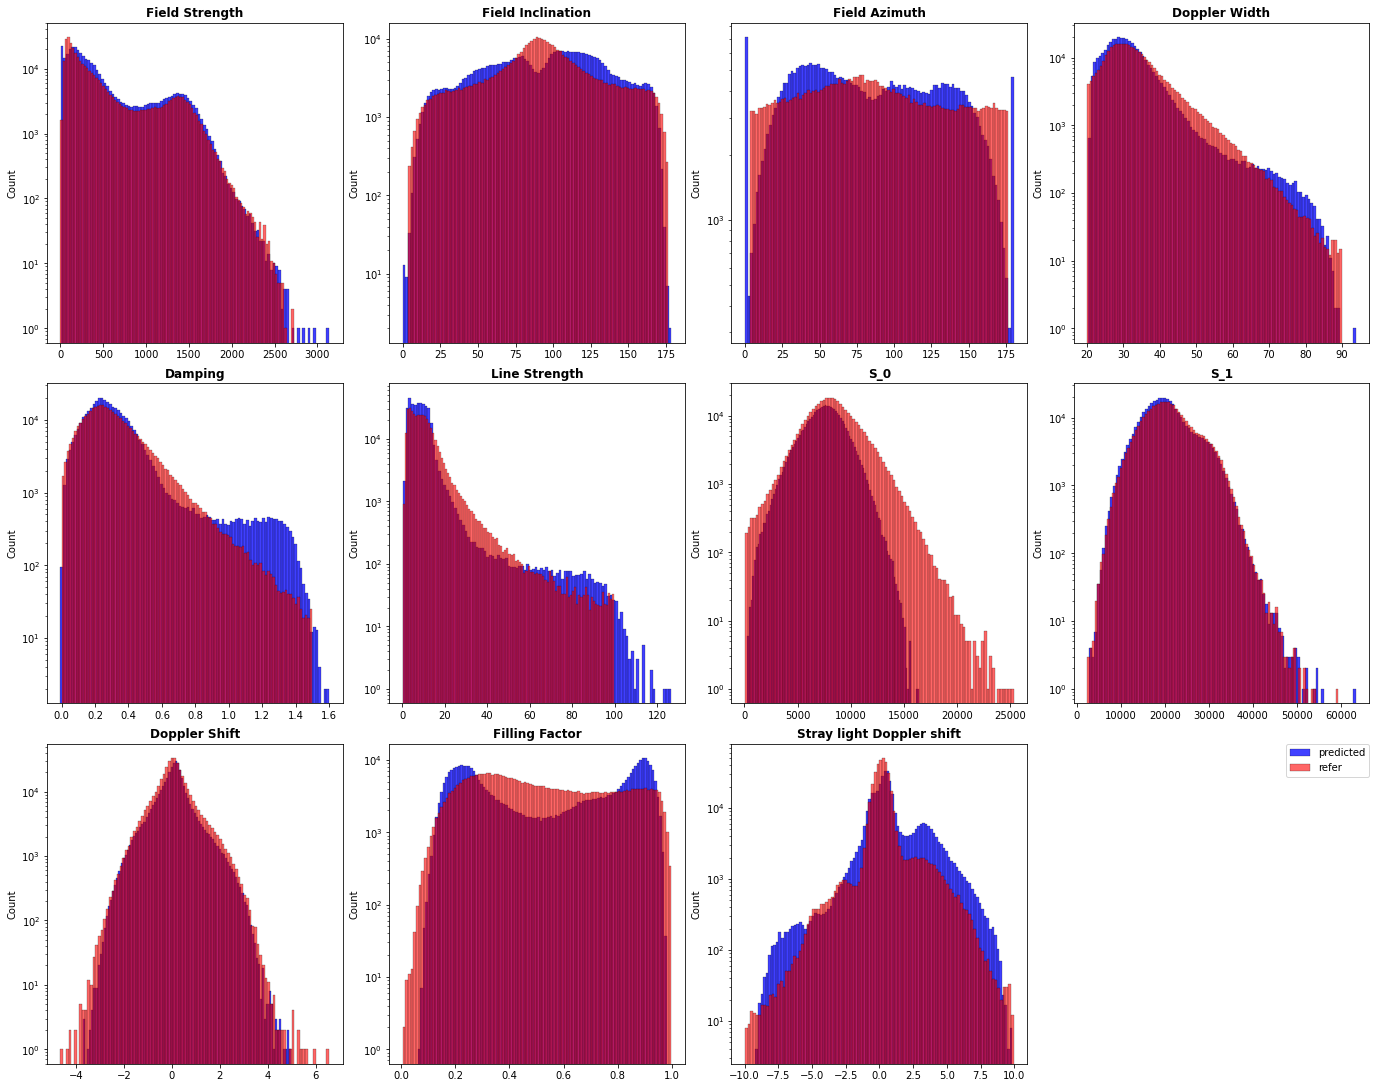

In [35]:
plot_hist_params_comparison(predicted_2d_inv, masked_ref_unnorm_2d.data, 
                            save_path=save_path+model_name+'_inv_comp_plot',
                            mask=masked_ref_2d.mask)
plt.show()

## Проверка на реальных спектрах

Спектры лежат в отдельной папочке sp_..... (много папочек в папочках, оставила так же как и лежит на хиноде). Спектры получаются последовательным сканированием щели, и результаты каждой в своем фитсе, всего 873, внутри каждой щели 512 спектров.

In [36]:
path_to_folder = '../data/hinode_source'
path_to_refer = '../data/hinode_source/20140926_170005.fits'

# date as a list with year, month,day, hour 
date = ['2014', '09', '26', '17']

sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')

sp_path = os.path.join(sp_folder, date[0], date[1], date[2], 'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]

sp_lines = sorted(glob.glob(sp_path + '*.fits'))
print(f'Number of files: {len(sp_lines)}')

Number of files: 873


Real spectrum for parameters
Model spectrum for parameters
Field_Strength: 483.10, Field_Inclination: 127.89, Field_Azimuth: 67.10, Doppler_Width: 25.90, Damping: 0.33, Line_Strength: 10.72, Source_Function: 8626.69, Source_Function_Gradient: 21277.41, Doppler_Shift2: -0.11, Stray_Light_Fill_Factor: 0.46, Stray_Light_Shift: -0.13


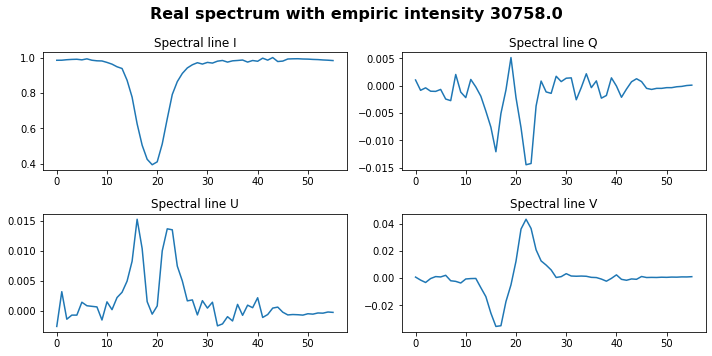

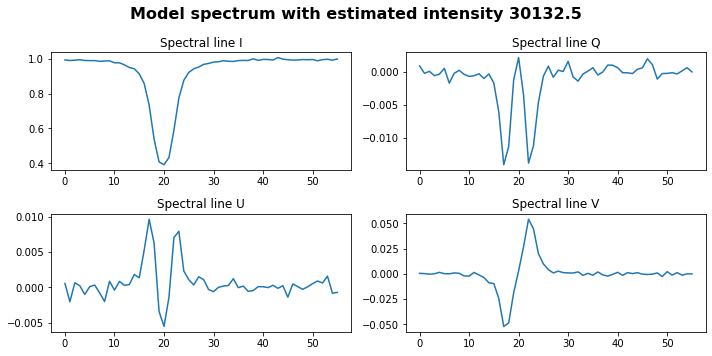

In [37]:
# можно побегать индексами и посравнивать спектры
idx_0, idx_1 = 22, 794
cont_int, real_line = plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1)
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
profile, cont_int = plot_model_spectrum(refer, names, idx_0, idx_1)

### Подготовка реальных спектров для модели

In [38]:
def prepare_real_conv(sp_folder, date, factors=None, cont_scale=None, device=None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1, 56, 4), order='F'),
                                           factors=factors)
    
    norm_cont = cont / cont_scale
    norm_real_samples = np.swapaxes(norm_real_samples, 1, 2)
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x

In [39]:
%%time

transform = conv1d_transform_rescale(factors=factors, 
                                     angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB)

test_dataset = PregenSpectrumDataset(data_arr=refer.reshape(-1, 11),
                                     transform=transform)

inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]

CPU times: user 50.4 s, sys: 15 s, total: 1min 5s
Wall time: 1min 5s


In [40]:
%%time

real_x = prepare_real_conv(sp_folder, date, factors=factors, cont_scale=cont_scale, device=device)

CPU times: user 5.51 s, sys: 2.52 s, total: 8.03 s
Wall time: 10.5 s


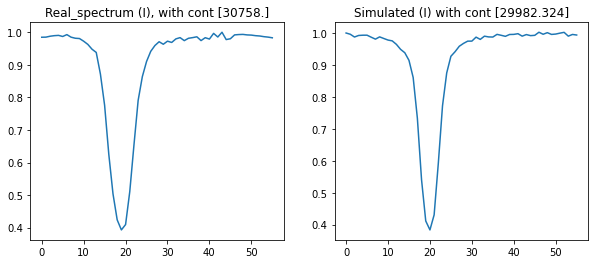

In [41]:
#тоже можно побегать индексом и увидеть, что наши симуляции довольно сильно отличаются
idx = 20000
#можно проверить, что все правильно сделали и посмотреть на координату пикселя
idx_0, idx_1 = np.where(np.arange(512 * 873).reshape(512, 873) == idx)

idx_0[0], idx_1[0] = idx_0, idx_1
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1); plt.plot(real_x[0][idx, 0].detach().cpu().numpy()); plt.title(f'Real_spectrum (I), with cont {real_x[1][idx].detach().cpu().numpy()*40000}')
plt.subplot(1,2,2);  plt.plot(sim_x[0][idx, 0].detach().cpu().numpy()); plt.title(f'Simulated (I) with cont {sim_x[1][idx].detach().cpu().numpy()*40000}');

In [42]:
model.eval()
with torch.no_grad():
    predicted_real = model(real_x)

In [43]:
predicted_real = predicted_real.detach().cpu().numpy()
predicted_real_2d = predicted_real.reshape(-1, 11).copy()

In [44]:
broken_rows = np.any((predicted_real_2d[:, [1,2]] > 1) + (predicted_real_2d[:, [1,2]] < 0), axis=1)
sum(broken_rows)

7548

In [45]:
mask_range = broken_rows[:, np.newaxis] | np.zeros_like(predicted_real_2d, dtype=bool)

predicted_real_2d_prep = predicted_real_2d.copy()

predicted_real_2d_prep[:, 1:3] = np.clip(predicted_real_2d_prep[:, 1:3], 0, 1)

In [46]:
inv_predicted_real_2d = inverse_transformation(predicted_real_2d_prep.copy(),
                                               inv_logB=logB,
                                               inv_angle_transformation=angle_transformation)

In [47]:
compute_metrics(refer, inv_predicted_real_2d,
                save_path=save_path+model_name+'_inv_real' + '.csv'
                mask=mask_range)

,r2,mse,mae
Field Strength,0.8964,3.386274e+04,120.8823
Field Inclination,0.8521,2.259648e+02,10.7950
Field Azimuth,0.5939,1.002725e+03,19.3026
Doppler Width,0.3773,5.892000e+01,5.1039
Damping,0.2831,3.920000e-02,0.1279
Line Strength,0.2422,1.032175e+02,4.3296
S_0,0.0368,1.146345e+07,2554.3870
S_1,0.6036,1.625333e+07,2948.8470
Doppler Shift,0.3853,8.595000e-01,0.6979
Filling Factor,0.1810,9.540000e-02,0.2306
